In [1]:
!nvidia-smi

Fri Dec 15 13:15:15 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [22]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
#!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
#!python rapidsai-csp-utils/colab/pip-install.py

In [ ]:
#pip install cudf-cu11==23.04 cuml-cu11==23.04 cugraph-cu11==23.04 cucim --extra-index-url=https://pypi.nvidia.com

In [5]:
pip install cudf-cu12==23.6.0 cuml-cu12==23.6.0 cugraph-cu12==23.6.0 cucim --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.3/493.3 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.1/959.1 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 705.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#!nvcc --version

In [3]:
import cuml
import numpy as np
from cuml.svm import SVC
from cuml.svm import LinearSVC
from cuml.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_classification

In [15]:
import pandas as pd
import os
import cv2
import numpy as np

from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import make_scorer, f1_score

from datetime import datetime
import time

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
def get_model_metrics(test_data, model, model_name):
    '''''''''
    Get binary classification metrics for a given model and saves the results to local directory
    '''''''''
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'

    if not os.path.exists(results_folder):
        os.makedirs(results_folder)

    predicted_probs = model.predict_proba(test_data[0])
    predicted_probs = predicted_probs[:, 1]
    true_labels = test_data[1]
    predicted_labels = model.predict(test_data[0])

    # determine the best threshold
    thresholds = np.linspace(0, 1, 100)
    best_f1 = 0
    best_threshold = 0.5
    for thresh in thresholds:
        predicted_labels = [1 if p > thresh else 0 for p in predicted_probs]
        f1 = f1_score(true_labels, predicted_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

    print(f"Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.2f}")

    # recalculate predictions with the best threshold
    final_predicted_labels = [1 if p > best_threshold else 0 for p in predicted_probs]

    # Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()

    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)

    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # ROC AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2)

    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)

    # plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip "/content/drive/MyDrive/TFM/GLCM_CIR.zip" -d "/content"

Archive:  /content/drive/MyDrive/TFM/GLCM_CIR.zip
  inflating: /content/X_test_CIR.csv  
  inflating: /content/X_train_CIR.csv  
  inflating: /content/y_test_CIR.csv  
  inflating: /content/y_train_CIR.csv  


In [8]:
X_train = np.loadtxt("/content/X_train_CIR.csv", delimiter=",")
y_train = np.loadtxt('/content/y_train_CIR.csv', delimiter=",")
X_test = np.loadtxt('/content/X_test_CIR.csv', delimiter=",")
y_test = np.loadtxt('/content/y_test_CIR.csv', delimiter=",")

In [9]:
scorer = make_scorer(f1_score, pos_label=1)

In [10]:
import time
s = time.time()
# Define the parameter grid
param_grid = {
    'C': [1, 10, 100, 1000, 10000],
    'kernel': ['rbf', 'poly'],
    'gamma': [0.001, 0.01, 0.1, 0.5],
    'class_weight': [None, 'balanced']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=10, scoring=scorer)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
e = time.time()
print(e-s)

Best Parameters: {'C': 1, 'class_weight': None, 'gamma': 0.001, 'kernel': 'rbf'}
Best Score: 0.0
82.02248096466064


In [11]:
best_params = grid_search.best_params_

In [12]:
best_svc_clf = SVC(**best_params, probability=True, random_state=42)

[W] [13:35:44.714061] Random state is currently ignored by probabilistic SVC


In [13]:
best_svc_clf.fit(X_train, y_train)

SVC()

Best threshold: 0.13 with F1-score: 0.15


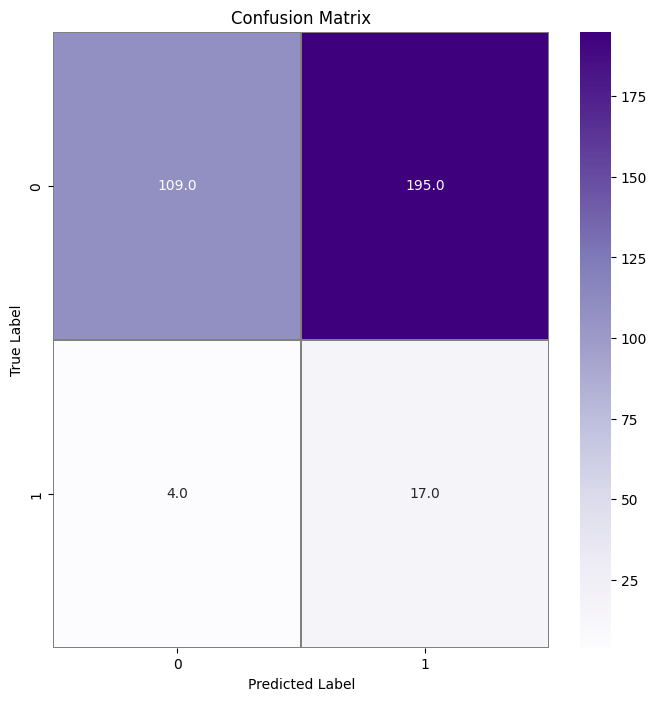

              precision    recall  f1-score   support

         0.0       0.96      0.36      0.52       304
         1.0       0.08      0.81      0.15        21

    accuracy                           0.39       325
   macro avg       0.52      0.58      0.33       325
weighted avg       0.91      0.39      0.50       325

     Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  CIR-SVC-poly  0.63                     0.15      0.39         0.81   

   Specificity   PPV   NPV   PLR   NLR  
0         0.36  0.08  0.96  1.26  0.53  


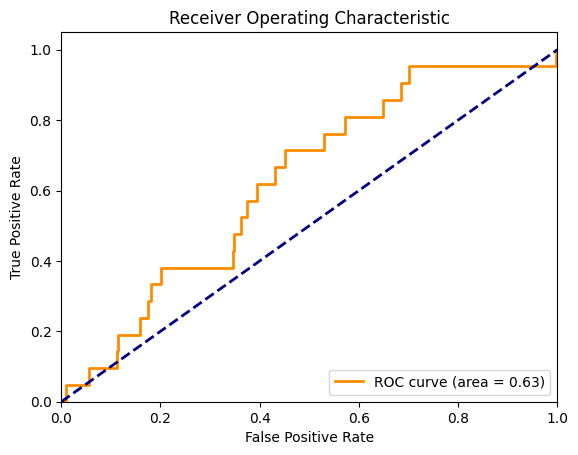

In [16]:
get_model_metrics(test_data=[X_test,y_test], model=best_svc_clf, model_name='CIR-SVC-poly')

In [17]:
import time
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')

s = time.time()
# Define the parameter grid
param_grid = {
    'C': [1, 10, 100, 1000, 10000],
    'class_weight': [None, 'balanced']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=LinearSVC(), param_grid=param_grid, cv=10, scoring=scorer)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
e = time.time()
print(e-s)


Best Parameters: {'C': 10, 'class_weight': 'balanced'}
Best Score: 0.021508908630204212
76.49251103401184


In [18]:
best_params = grid_search.best_params_

In [19]:
best_svc_clf = SVC(**best_params, probability=True, random_state=42)

[W] [13:41:07.523582] Random state is currently ignored by probabilistic SVC


In [20]:
best_svc_clf.fit(X_train, y_train)

[W] [13:41:08.154546] Warning: could not fill working set, found only 918 elements
[W] [13:41:08.157443] Warning: could not fill working set, found only 1016 elements
[W] [13:41:08.159606] Warning: could not fill working set, found only 919 elements
[W] [13:41:08.211688] Warning: could not fill working set, found only 950 elements
[W] [13:41:08.214825] Warning: could not fill working set, found only 1011 elements
[W] [13:41:08.217945] Warning: could not fill working set, found only 952 elements
[W] [13:41:08.271115] Warning: could not fill working set, found only 1005 elements
[W] [13:41:08.276405] Warning: could not fill working set, found only 1019 elements


SVC()

Best threshold: 0.00 with F1-score: 0.12


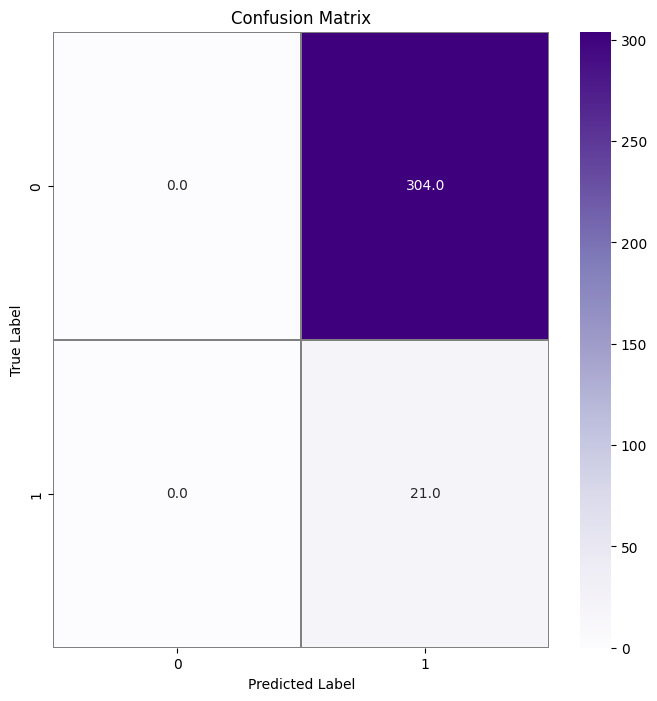

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       304
         1.0       0.06      1.00      0.12        21

    accuracy                           0.06       325
   macro avg       0.03      0.50      0.06       325
weighted avg       0.00      0.06      0.01       325

       Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  CIR-SVC-linear  0.45                     0.12      0.06          1.0   

   Specificity   PPV  NPV  PLR  NLR  
0          0.0  0.06  NaN  1.0  NaN  


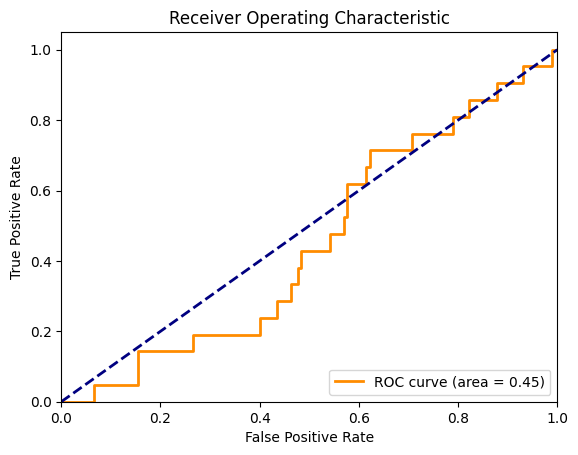

In [21]:
get_model_metrics(test_data=[X_test,y_test], model=best_svc_clf, model_name='CIR-SVC-linear')